# Scan of dark Fits Files of Monocam
================================================================

- Date of creation : Friday 27th 2016
- Update : June 2nd 2016
- Author : Sylvie Dagoret-Campagne
- Affiliation : LAL/IN2P3/CNRS

In [28]:
import numpy as np

# Set up matplotlib and use a nicer set of plot parameters
#config InlineBackend.rc = {}
#config Backend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")  # default config obtained from astropy examples
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [29]:
from astropy.utils.data import download_file
from astropy.io import fits
from astropy import units as u
import os
import ccdproc

In [30]:
import pandas as pd
from datetime import datetime, timedelta
from pytz import timezone
import pytz

## 1) Configuration of input files

### 1.1) The input dark files

In [31]:
# darks at the beginning
path='/Users/dagoret-campagnesylvie/iraf/MonoCamMay2016/20160509'
root_filename='dark_'
ext_filename='.fits'
startnum=1
stopnum=40
#stopnum=63
date=datetime(2016,5,9)  # 2016-05-10T01:07:55.503
nb_of_channels=16  # number of CCD amplifier channels corresponding to an image inside the fits file

In [32]:
# darks at the end
#path='/Users/dagoret-campagnesylvie/iraf/MonoCamMay2016/20160509'
#root_filename='mdark_'
#ext_filename='.fits'
#startnum=1
#stopnum=35
#date=datetime(2016,5,9)  # 2016-05-10T01:07:55.503
#nb_of_channels=16  # number of CCD amplifier channels corresponding to an image inside the fits file

In [33]:
# the bias master file
masterbias_filename='masterbias1.fits'
masterbias_file=os.path.join(path,masterbias_filename)

In [34]:
def Buildfilename(path,name,ext,num):
    '''
    input:
       path : path of bias files
       name : common root of bias filenames
       ext  : extension of filenames
    output:
       full filename 
    '''
    strnum= '{0:02d}'.format(num)  # python >= 2.6
    filename=name+strnum+ext
    fullfilename=os.path.join(path,filename)
    return fullfilename

In [35]:
filelist= [Buildfilename(path,root_filename,ext_filename,num) for num in range(startnum,stopnum+1,1)]

In [36]:
nbfiles=len(filelist)

### 1.2) configuration of date

In [37]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-06-05 09:17:44.625992
fits date format for the analysis :  2016-06-05T09:17:44


## 2) Exposure

- compute the mean and RMS of the darks for all the pixels

In [38]:
NBCHAN=16
NBFILES=nbfiles

# arrays initialisation
means0=np.zeros((NBCHAN,NBFILES),dtype=np.float)
rms0=np.zeros((NBCHAN,NBFILES),dtype=np.float)
means=np.zeros((NBCHAN,NBFILES),dtype=np.float)
rms=np.zeros((NBCHAN,NBFILES),dtype=np.float)

list_exposures=np.zeros(NBFILES,dtype=np.float)

# loop on files
for file in range(0,nbfiles):
    hdu_list = fits.open(filelist[file])
    header=hdu_list[0].header
    number_of_channels=header['CHAN']
    exposure=header['EXPOSURE']
    list_exposures[file]=exposure
    # loop on channels
    for numchan in range(1,number_of_channels+1):
        image_data = hdu_list[numchan].data
        nrow,ncol =image_data.shape
        # extract the two quatities
        firstcol = image_data[:,0]
        othercol = image_data[:,1:ncol]
        # flatten the arrays
        lowvalue = firstcol.flatten()
        highvalue = othercol.flatten()
        # extract mean and rms
        means0[numchan-1,file]=lowvalue.mean()
        rms0[numchan-1,file]=lowvalue.std()
        means[numchan-1,file]=highvalue.mean()
        rms[numchan-1,file]=highvalue.std()        
                

### 2.1) Show exposure versus time

-exposure recorded in fits header file

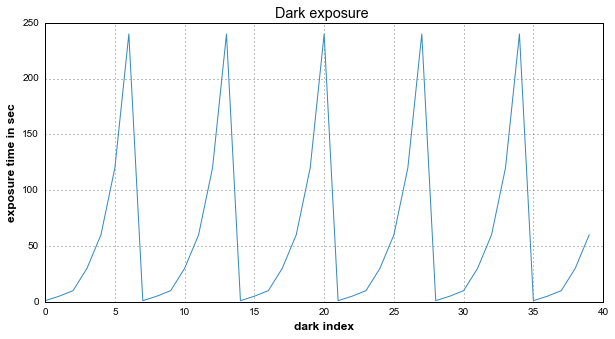

In [39]:
title='Dark exposure '
fig = plt.figure(figsize=(10,5))
plt.plot(range(NBFILES),list_exposures)    
plt.title(title)
plt.xlabel('dark index')
plt.ylabel('exposure time in sec')
plt.grid(True)

### 2.2) Dark versus time

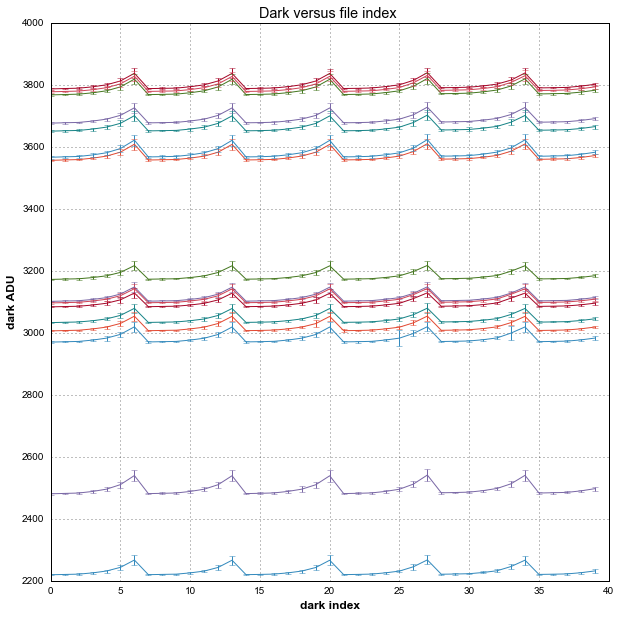

In [40]:
title='Dark versus file index '
fig = plt.figure(figsize=(10,10))
for numchan in range(0,number_of_channels):
    plt.errorbar(range(NBFILES),means[numchan,:],yerr=rms[numchan,:])
    
plt.title(title)
plt.xlabel('dark index')
plt.ylabel('dark ADU')
plt.grid(True)

### 2.3) Dark versus index in each amplifier

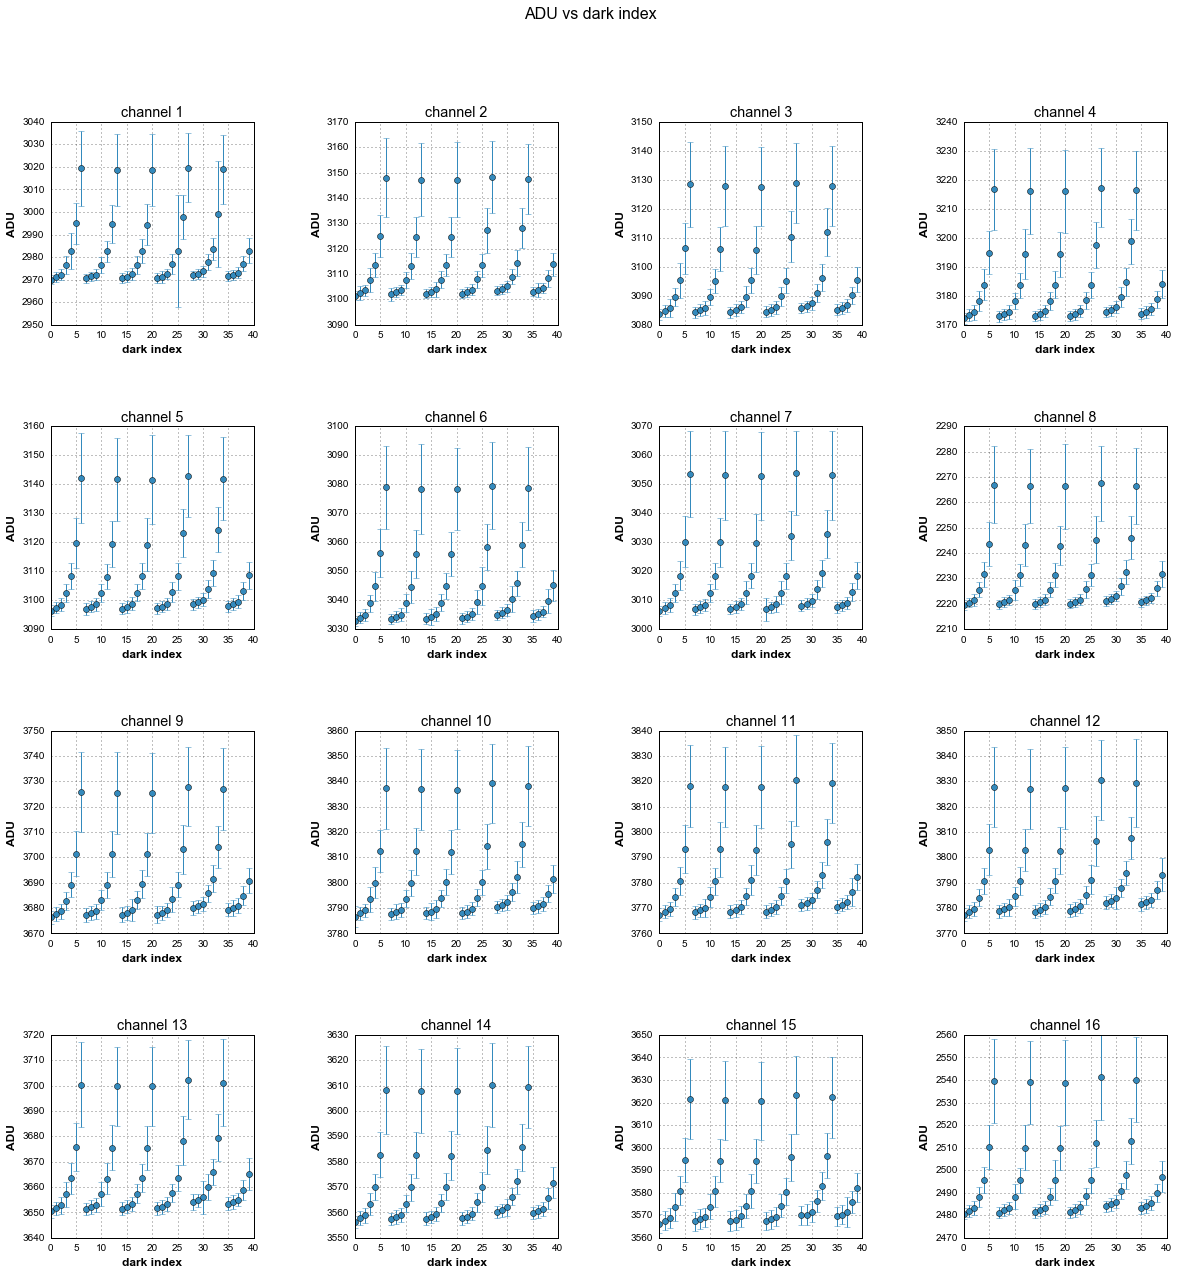

In [41]:
NX=4 # number of images along the horizontal axis
NY=4 # number of images along the vertical axis
f, axarr = plt.subplots(NY,NX,figsize=(20,20)) # figure organisation
#f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
f.subplots_adjust(hspace=0.5,wspace=0.5)

for index in range(0,number_of_channels):  
    ix=index%4
    iy=index/4
    numchan=index
    axarr[iy,ix].errorbar(range(NBFILES),means[numchan,:],yerr=rms[numchan,:],fmt='o')
    plottitle='channel {}'.format(index+1)
    axarr[iy,ix].set_title(plottitle)
    axarr[iy,ix].set_ylabel('ADU')
    axarr[iy,ix].set_xlabel('dark index')
    axarr[iy,ix].grid(True)

title='ADU vs dark index'
plt.suptitle(title,size=16)
plt.show()


### 2.4) Darks In Biassec

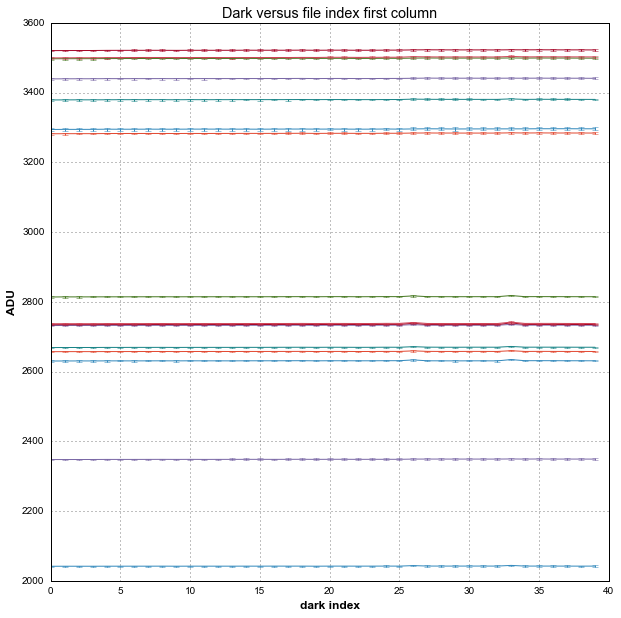

In [42]:
title='Dark versus file index first column'
fig = plt.figure(figsize=(10,10))
for numchan in range(0,number_of_channels):
    plt.errorbar(range(NBFILES),means0[numchan,:],yerr=rms0[numchan,:])
    
plt.title(title)
plt.xlabel('dark index')
plt.ylabel('ADU')
plt.grid(True)

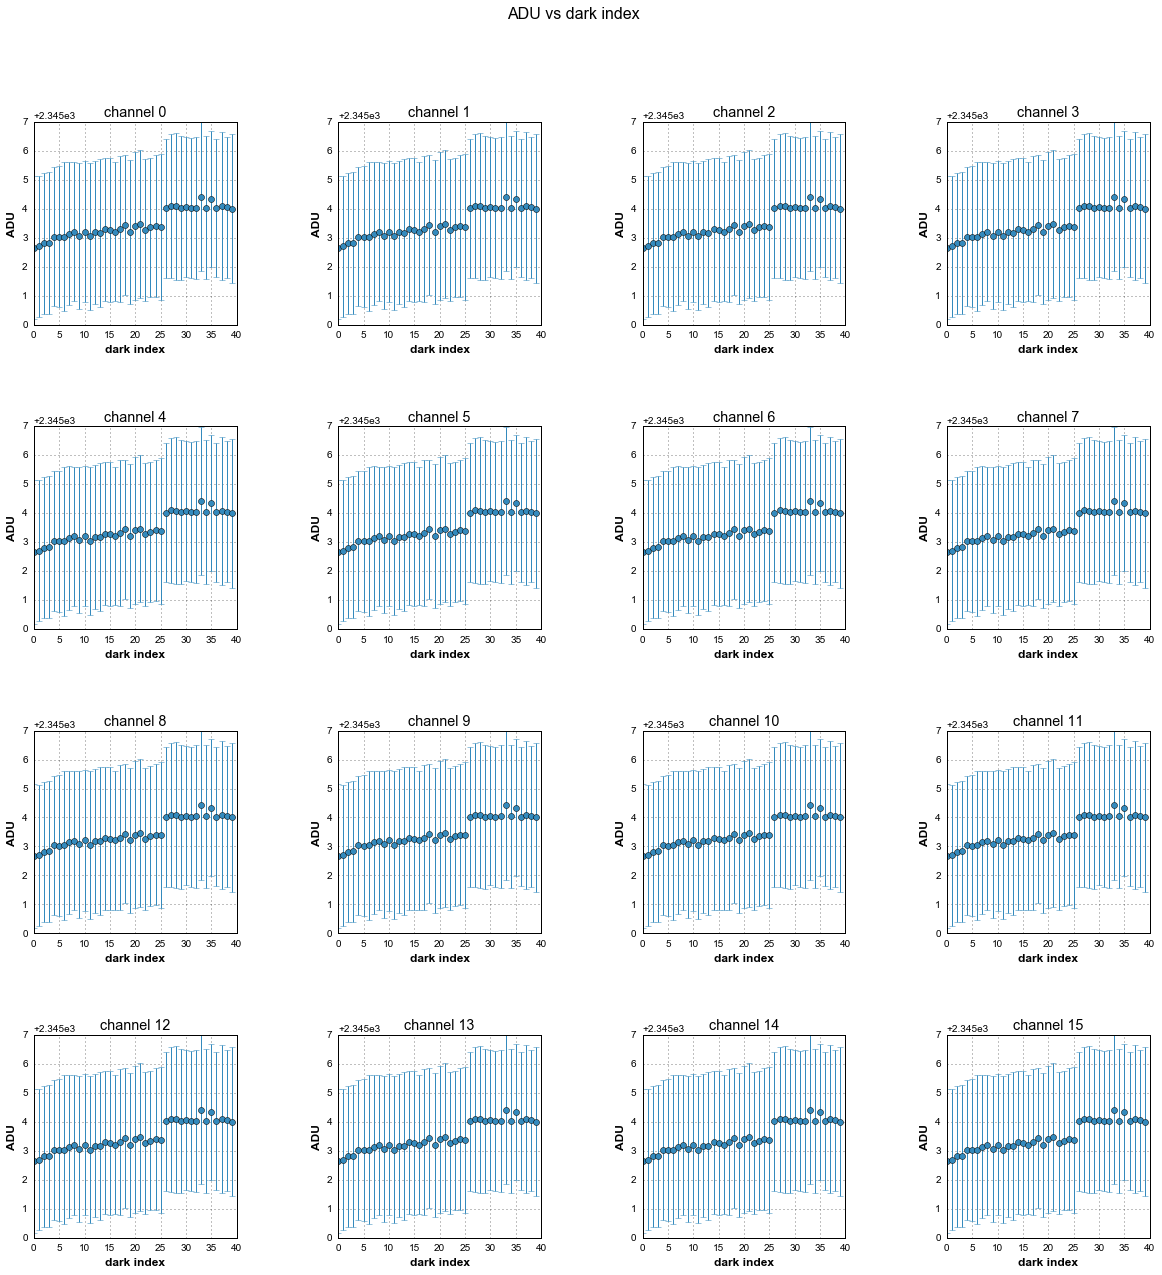

In [43]:
NX=4 # number of images along the horizontal axis
NY=4 # number of images along the vertical axis
f, axarr = plt.subplots(NY,NX,figsize=(20,20)) # figure organisation
#f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
f.subplots_adjust(hspace=0.5,wspace=0.5)

for index in range(0,number_of_channels):  
    ix=index%4
    iy=index/4
        
    axarr[iy,ix].errorbar(range(NBFILES),means0[numchan,:],yerr=rms0[numchan,:],fmt='o')
    plottitle='channel {}'.format(index)
    axarr[iy,ix].set_title(plottitle)
    axarr[iy,ix].set_ylabel('ADU')
    axarr[iy,ix].set_xlabel('dark index')
    axarr[iy,ix].grid(True)
    
title='ADU vs dark index'
plt.suptitle(title,size=16)
plt.show()

## 3) Substraction of Master Bias to the Dark

### 3.1 Read All Master-Biases

In [44]:
masterbiases = [ ccdproc.CCDData.read(masterbias_file, hdu=chan,unit="adu") for chan in range(1,nb_of_channels+1,1) ]

### 3.2 Put all darks inside a list of CCDDATA list

In [45]:
# all CCDPROC data collector : each channel as a list of dark data
alldarks = []

In [46]:
for chan in range(1,nb_of_channels+1,1):
    ccd_chan = [ ccdproc.CCDData.read(image_file, hdu=chan,unit="adu") for image_file in filelist ]
    alldarks.append(ccd_chan)

### 3.3 Substract the masterbias to the Darks 

In [47]:
mbias_and_darks=zip(masterbiases, alldarks)

In [48]:
list_subdarks= []  # list of list of substracted darks, one list per channel
for mb,darks in mbias_and_darks:
    list_d=[]      # list of substracted darks for the current channel
    for d in darks:
        nd=ccdproc.subtract_bias(d,mb)
        list_d.append(nd)
    list_subdarks.append(list_d)   

## 4) Show the Flat versus Exposure

### 4.1) Compute the average dark

In [49]:
# book the arrays in advance

newmeans=np.zeros((NBCHAN,NBFILES),dtype=np.float)
newrms=np.zeros((NBCHAN,NBFILES),dtype=np.float)
newexpo=np.zeros((NBCHAN,NBFILES),dtype=np.float)

for fileindex in range(0,nbfiles):
    Xpos=list_exposures[fileindex]
    for channel in range(0,nb_of_channels):       
        newmeans[channel,fileindex]=list_subdarks[channel][fileindex].data.mean()
        newrms[channel,fileindex]=list_subdarks[channel][fileindex].data.std()
        newexpo[channel,fileindex]=Xpos

### 4.2) Plot Dark vs Exposure for each channels

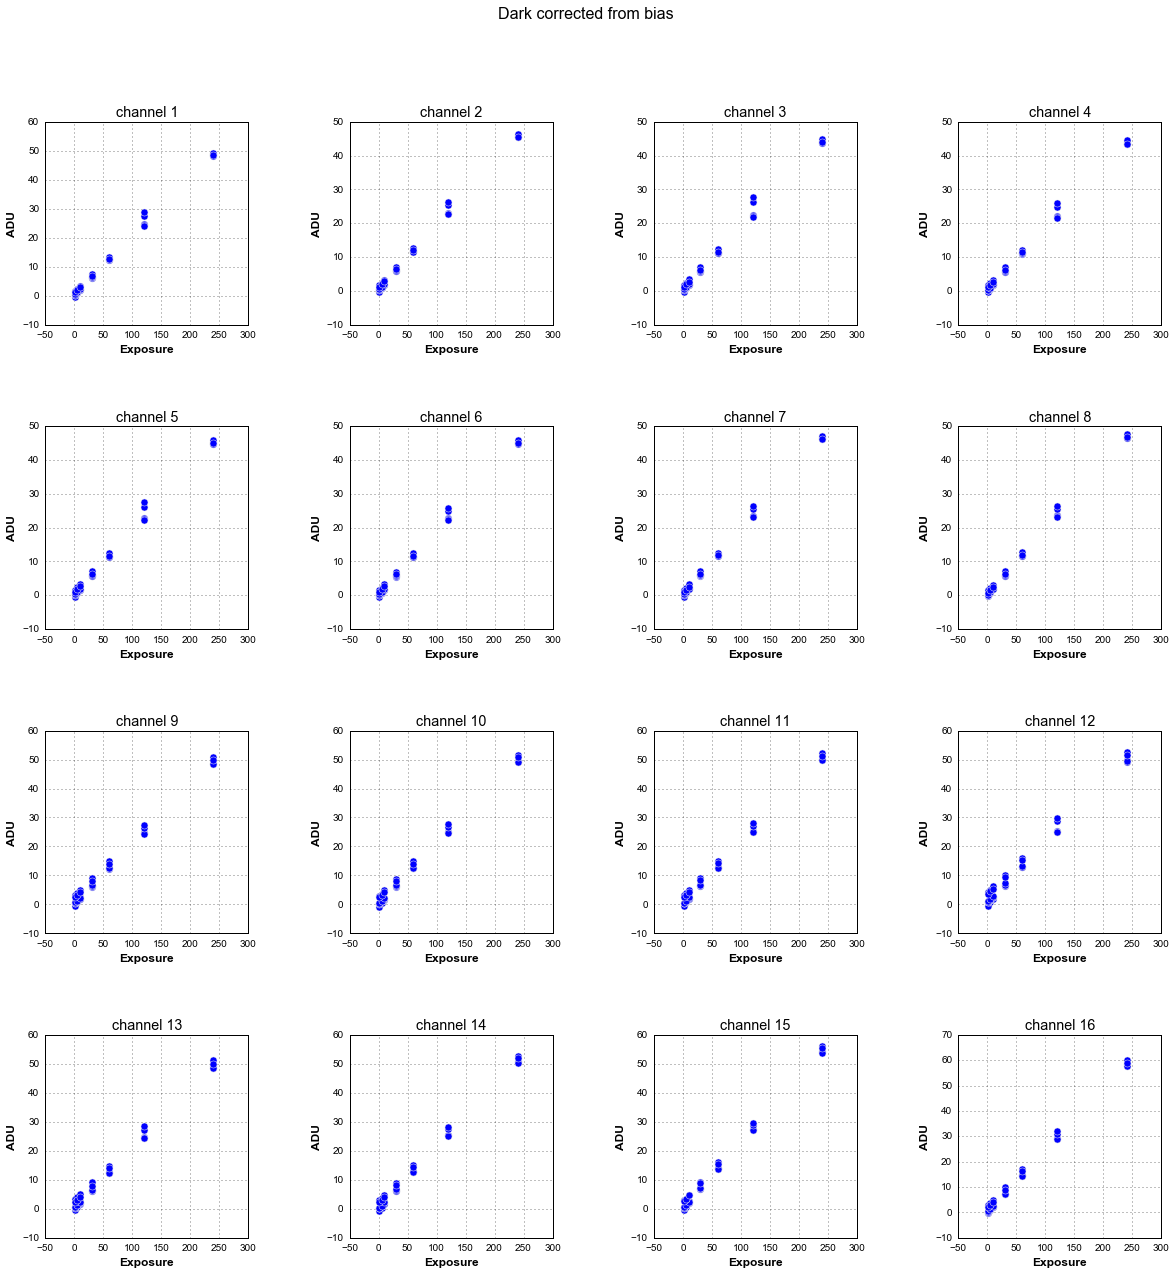

In [50]:
NX=4 # number of images along the horizontal axis
NY=4 # number of images along the vertical axis
f, axarr = plt.subplots(NY,NX,figsize=(20,20)) # figure organisation
#f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
f.subplots_adjust(hspace=0.5,wspace=0.5)

for index in range(0,number_of_channels):  
    ix=index%4
    iy=index/4
    numchan=index
    axarr[iy,ix].scatter(newexpo[numchan,:],newmeans[numchan,:],s=50,marker='o')
    plottitle='channel {}'.format(index+1)
    axarr[iy,ix].set_title(plottitle)
    axarr[iy,ix].set_ylabel('ADU')
    axarr[iy,ix].set_xlabel('Exposure')
    axarr[iy,ix].grid(True)

title='Dark corrected from bias'
plt.suptitle(title,size=16)
plt.show()

### 4.3) Plot Dark vs Exposure all channels 

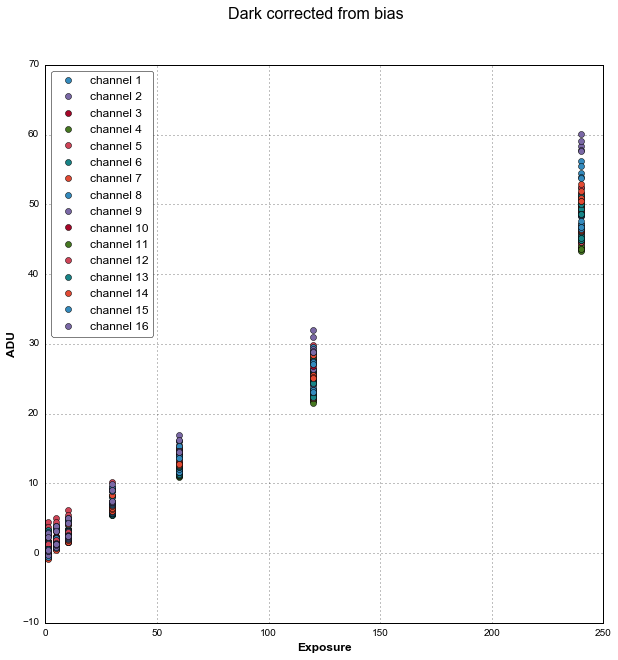

In [51]:
NX=1 # number of images along the horizontal axis
NY=1 # number of images along the vertical axis
f, axarr = plt.subplots(NY,NX,figsize=(10,10)) # figure organisation

for index in range(0,number_of_channels):      
    numchan=index
    lab='channel {}'.format(index+1)
    plt.plot(newexpo[numchan,:],newmeans[numchan,:],'o',label=lab)
    
plt.ylabel('ADU')
plt.xlabel('Exposure')
plt.grid(True)
plt.legend(loc='best')

title='Dark corrected from bias'
plt.suptitle(title,size=16)
plt.show()